In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

Top features for PC1:
  A: 0.3037
  K: -0.2694
  GAC: 0.2638
  GTC: 0.2497
  GCG: 0.2409
Top features for PC2:
  E: 0.4807
  GAG: 0.4683
  T: -0.2244
  A: -0.2061
  AAG: 0.2007


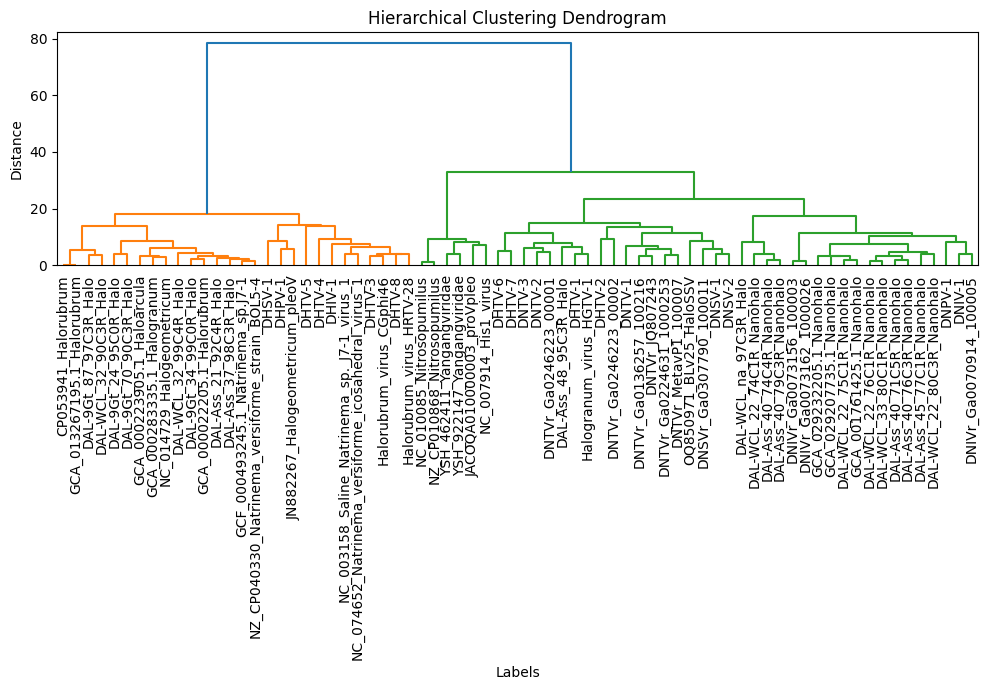

In [2]:
# Load the TSV file into a pandas DataFrame
file_path = 'for_PCA.tsv'  
data = pd.read_csv(file_path, sep='\t', index_col=0)

group_file = 'groups.csv'  
group_data = pd.read_csv(group_file)  

# Separate features and labels
features = data.index
labels = data.columns
data_matrix = data.values.T  # Transpose so features are columns

if not set(labels).issubset(set(group_data['genome'])):
    raise ValueError("Some labels in the data file do not have a group in the grouping file.")

# Merge the grouping info into the data
group_data = group_data.set_index('genome').reindex(labels)
groups = group_data['Group']

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_matrix)

# Identify features contributing most to variance
explained_variance = pca.explained_variance_ratio_
components = pca.components_

# Top features for each component
top_features_per_component = {}
for i, component in enumerate(components):
    top_indices = np.argsort(np.abs(component))[::-1]  # Sort by absolute contribution
    top_features = [(features[j], component[j]) for j in top_indices[:5]]  # Top 5 features
    top_features_per_component[f'PC{i+1}'] = top_features

# Print top features per principal component
top_feat = []
for pc, top_features in top_features_per_component.items():
    print(f"Top features for {pc}:")
    for feature, contribution in top_features:
        print(f"  {feature}: {contribution:.4f}")
        top_feat.append(feature)

# Perform hierarchical clustering on the labels
linkage_matrix = linkage(data_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Labels")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [3]:
# retrieve PC components
pc1 = np.array(pca.components_[0])
pc2 = np.array(pca.components_[1])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


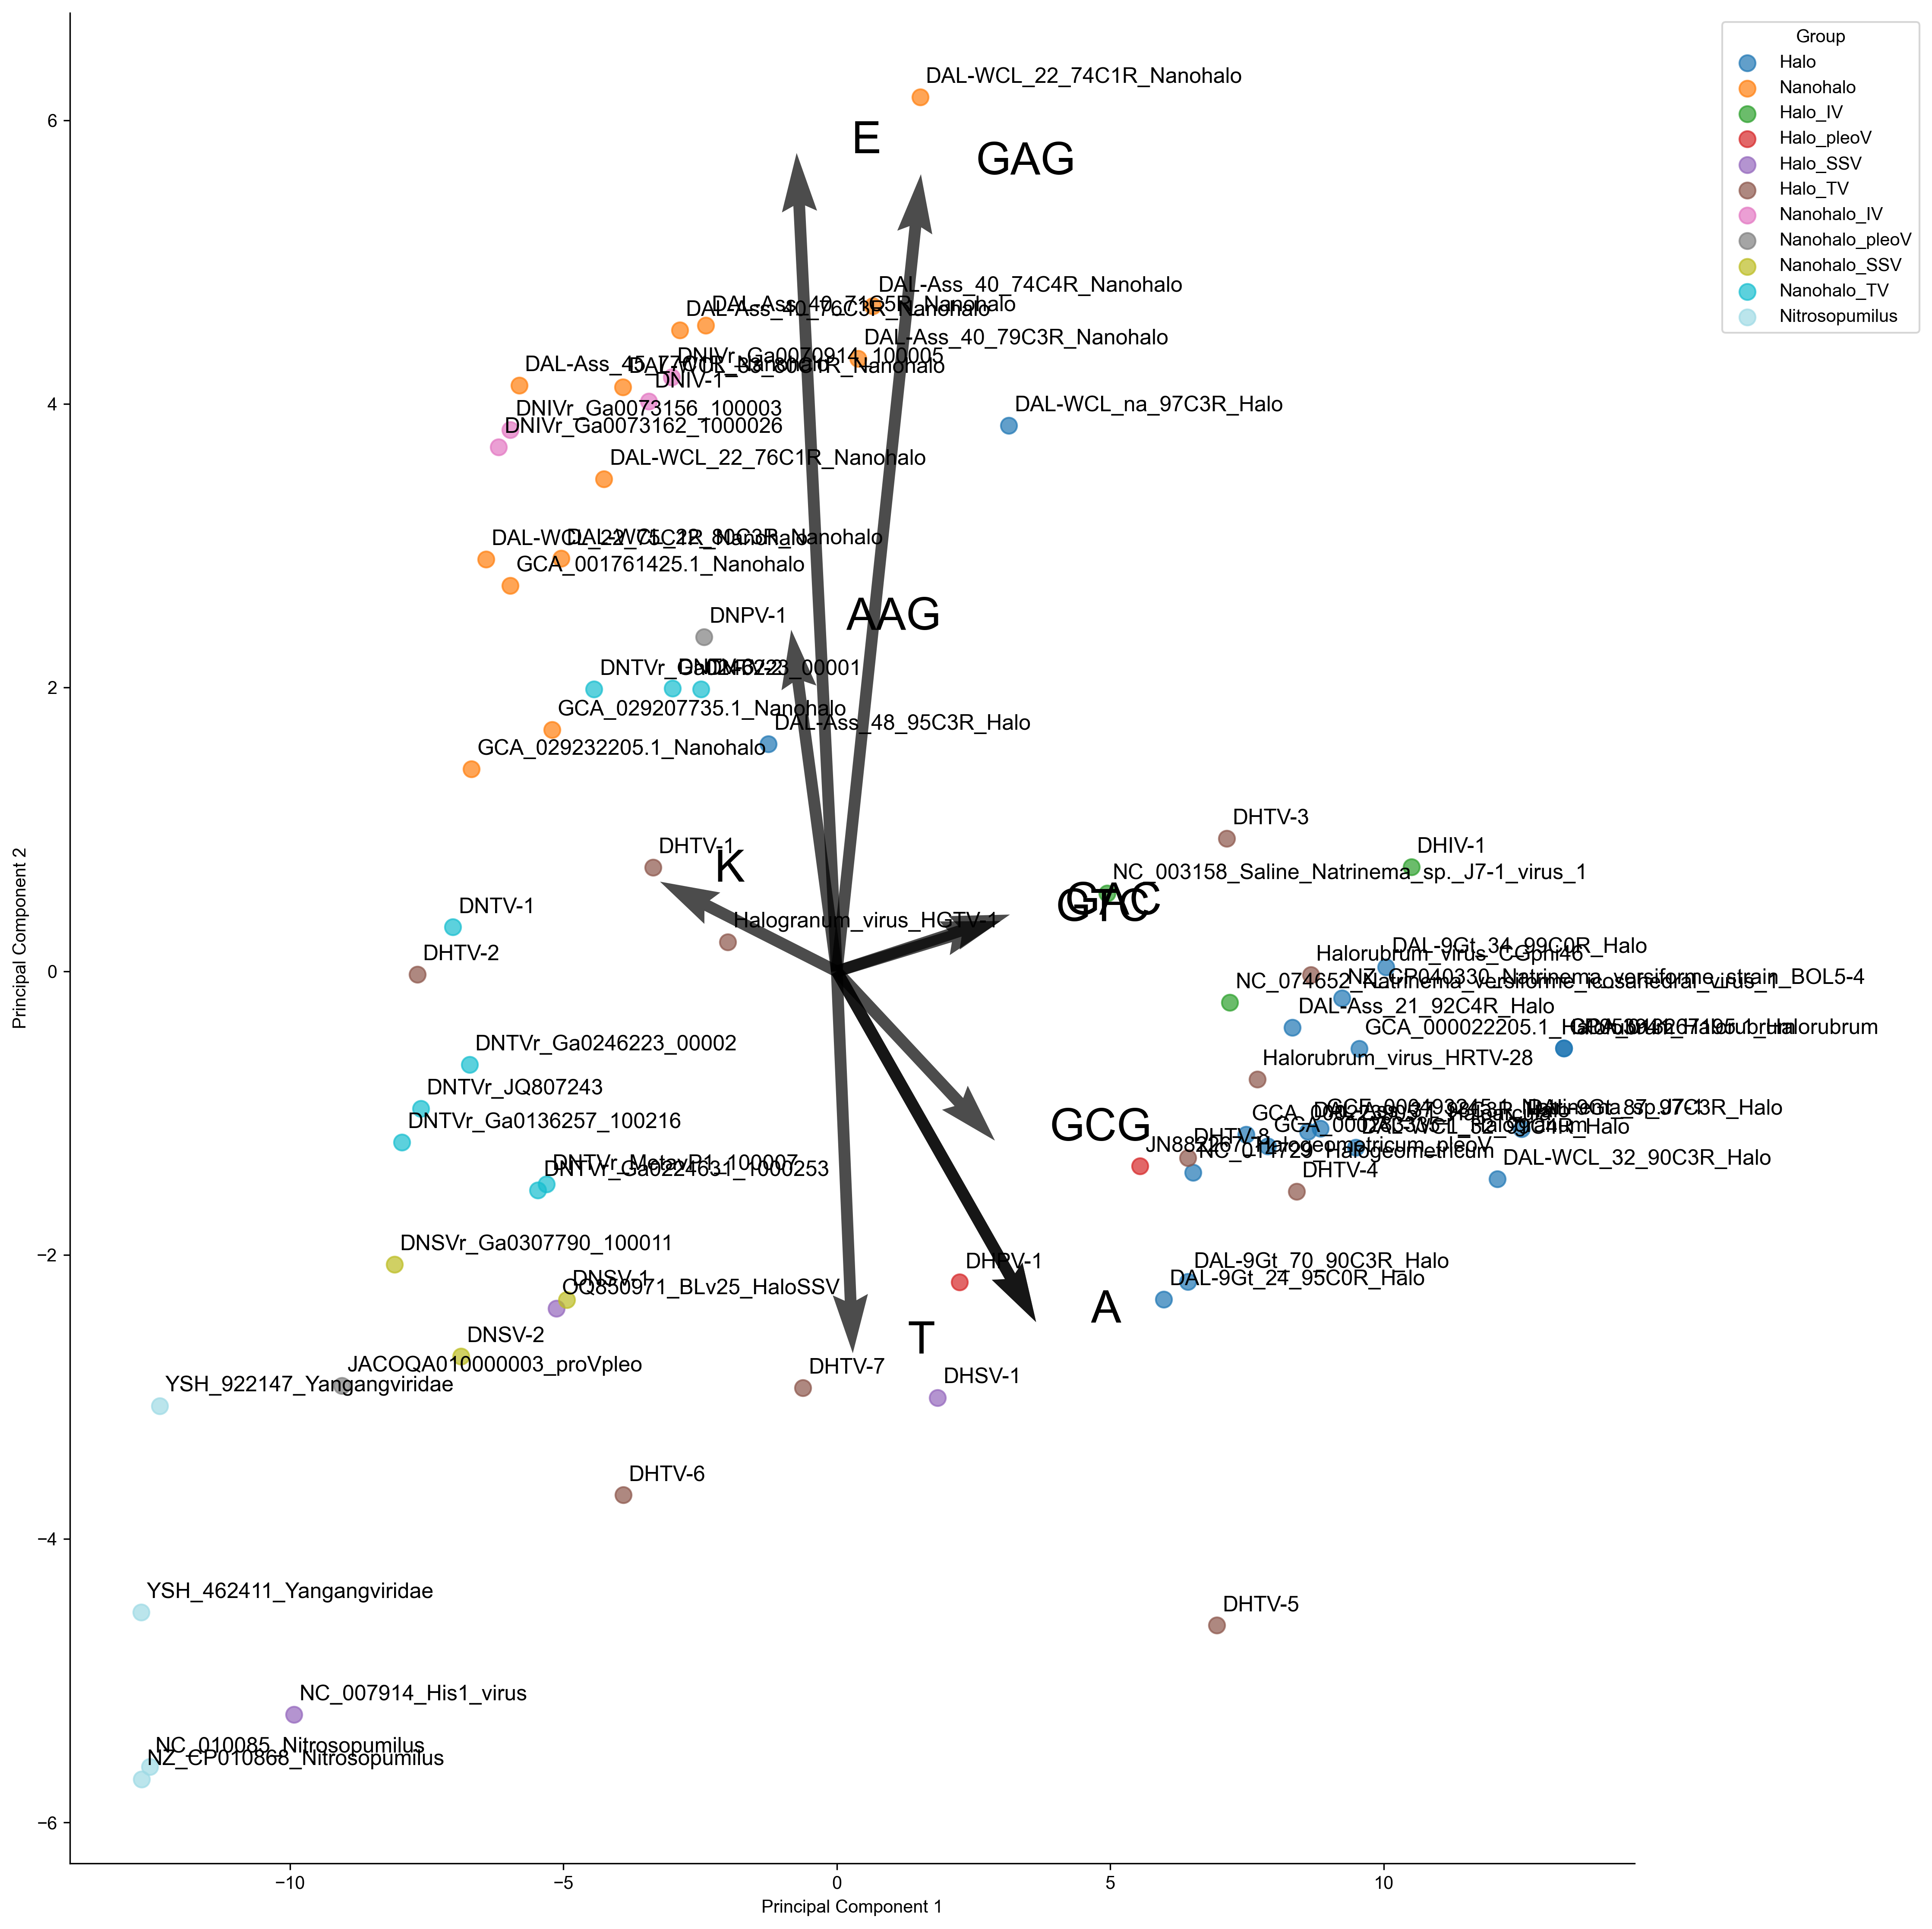

In [8]:

unique_groups = groups.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_groups)))  # Generate unique colors for groups

# Plotting
plt.rcParams['font.sans-serif'] = "Arial"
    # Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

fig,ax = plt.subplots(figsize=(15,15), dpi=300)

for group, color in zip(unique_groups, colors):
    indices = groups == group
    ax.scatter(
        pca_result[indices, 0],
        pca_result[indices, 1],
        label=group,
        color=color,
        alpha=0.7,
        s=80,
    )

for i, item in enumerate(labels.tolist()):
    ax.text(pca_result[i,0] + 0.1, pca_result[i,1] + 0.1, item, fontsize=12)

scaling_factor = 12  # Adjust this factor to scale the arrows (big plot = big scaling factor)
# Add arrows for each feature

for __, item in enumerate(top_feat):
    # find the original index of the top feature
    idx = features.tolist().index(item)
    # pc1[i] and pc2[i] represent the component contribution of the feature in PC1 and PC2
    ax.quiver(0, 0, pc1[idx] * scaling_factor, pc2[idx] * scaling_factor, angles='xy', scale_units='xy', scale=1, color='black', alpha=0.7)
    
    # Add a label for each arrow (feature)
    plt.text(pc1[idx] * scaling_factor + 1 , pc2[idx] * scaling_factor, item, color='black', fontsize=25)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('PCA.svg', format='svg')
plt.savefig('PCA.eps', format='eps')
plt.savefig('PCA.pdf', format='pdf')
plt.show()